# Updated draft of evaluation

for each FUA:
* load data
* create evaluation grids
* load info on which cells are still under manual revision (exclude from evaluation FOR NOW)
* for each evaluation variable, check how errors are distributed: on map; by method

In [ ]:
import os
import pathlib

import folium
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import momepy as mm
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde

from core import stats, utils, viz

# %watermark -w
# %watermark -iv

Define which variables to evaluate

In [4]:
# which variables to evaluate
eval_vars = [
    "edge_count",
    "edge_length",
    "node_count",
    "avg_degree",
    "stroke_count",
    "stroke_length_sum",
    "stroke_length_max",
]

Define which methods to evaluate

In [5]:
# which methods to evaluate
methods_to_evaluate = [
    "cityseer",
    "manual",
    "original",
    "osmnx",
    # "parenx-voronoi",
    # "parenx-skeletonize",
    "neatnet",
]

Define which method pairs to compare

In [6]:
# which method pairs to compare
methodpairs_to_compare = [
    ("cityseer", "manual"),
    ("original", "manual"),
    ("osmnx", "manual"),
    # ("parenx-voronoi", "manual"),
    # ("parenx-skeletonize", "manual"),
    ("neatnet", "manual"),
]

Directories for evaluation results

In [7]:
evalfolder = "../../evaluation/"
os.makedirs(evalfolder, exist_ok=True)
subfolders = [evalfolder + str(fua) for fua in utils.fua_city]
for sub in subfolders:
    os.makedirs(sub, exist_ok=True)

Choose use case (FUA)

**once workflow is fixed: run for all FUAs**

In [8]:
# which FUA?
fua = 869

# which h3 resolution?
res = 9

In [9]:
# read in base data
meta = utils.read_sample_data()
geom = meta.loc[meta.eFUA_ID == fua, "geometry"]
city = meta.loc[meta.eFUA_ID == fua, "eFUA_name"].values[0]

gdf_orig = utils.read_original(fua)
proj_crs = gdf_orig.crs

# Make grid
base_grid = utils.make_grid(fua, res, proj_crs)

# get info on cells with to-be-revised data
deltas = gpd.read_file(f"../../revision/{fua}/deltas.gpkg")

In [10]:
# read results from all methods into dict
methods = {}

for method in methods_to_evaluate:
    print(f"Reading in results for {method}")
    gdf = utils.read_results(fua, method, proj_crs)
    gdf = gdf[~gdf.normalize().duplicated()].copy().reset_index(drop=True)
    G = mm.gdf_to_nx(gdf, length="length", integer_labels=True)
    nodes, edges = mm.nx_to_gdf(G)

    # add node degrees
    nodes = stats.add_node_degree(nodes, G)

    # add stroke IDs
    coins = mm.COINS(edges, angle_threshold=120, flow_mode=True)
    edges["stroke_id"] = coins.stroke_attribute()
    stroke_gdf = coins.stroke_gdf()

    methods[method] = {}
    methods[method]["gdf"] = gdf
    methods[method]["graph"] = G
    methods[method]["nodes"] = nodes
    methods[method]["edges"] = edges

    ### grid with stats eval for this method only
    grid = base_grid.copy()

    # add ratio columns to grid
    grid[["edge_count", "edge_length"]] = grid.apply(
        lambda x: stats.get_edge_stats(edges, x.geometry),  # noqa: B023
        axis=1,
        result_type="expand",
    )
    grid[["node_count", "node_degrees", "avg_degree"]] = grid.apply(
        lambda x: stats.get_node_stats(nodes, x.geometry),  # noqa: B023
        axis=1,
        result_type="expand",
    )

    grid[["stroke_count", "stroke_length_sum", "stroke_length_max"]] = grid.apply(
        lambda x: stats.get_stroke_stats(edges, stroke_gdf, x.geometry),  # noqa: B023
        axis=1,
        result_type="expand",
    )

    # add info on which cells have to be verified still
    grid["to_verify_total"] = deltas["to_verify_total"]

    # save grid to dict
    methods[method]["grid"] = grid

Reading in results for cityseer
Reading in results for manual
Reading in results for original
Reading in results for osmnx


/Users/anvy/Library/CloudStorage/OneDrive-ITU/postdoc/projects/neatnet/simplification/.pixi/envs/tests/lib/python3.12/site-packages/momepy/coins.py:103: UserWarning: Lines are between points dict_keys([(307372.6596990466, -4086598.4833908863), (307374.4710850579, -4086592.264577373)]) identical. Please revise input data to ensure no lines are identical or overlapping. You can check for duplicates using `gdf.geometry.duplicated()`. Assumingan angle of 0 degrees.
  self._best_link()
/Users/anvy/Library/CloudStorage/OneDrive-ITU/postdoc/projects/neatnet/simplification/.pixi/envs/tests/lib/python3.12/site-packages/momepy/coins.py:103: UserWarning: Lines are between points dict_keys([(307403.36733414815, -4086508.817736878), (307395.74122443737, -4086507.2754839086)]) identical. Please revise input data to ensure no lines are identical or overlapping. You can check for duplicates using `gdf.geometry.duplicated()`. Assumingan angle of 0 degrees.
  self._best_link()
/Users/anvy/Library/CloudS

Reading in results for neatnet


**Edge count**

In [ ]:
## plotting parameters
coldict = {"cityseer": "red", "neatnet": "green", "osmnx": "grey"}
zorders = {"cityseer": 1, "neatnet": 2, "osmnx": 0}
alphas = {"cityseer": 0.3, "neatnet": 0.5, "osmnx": 0.1}

'not weighted'

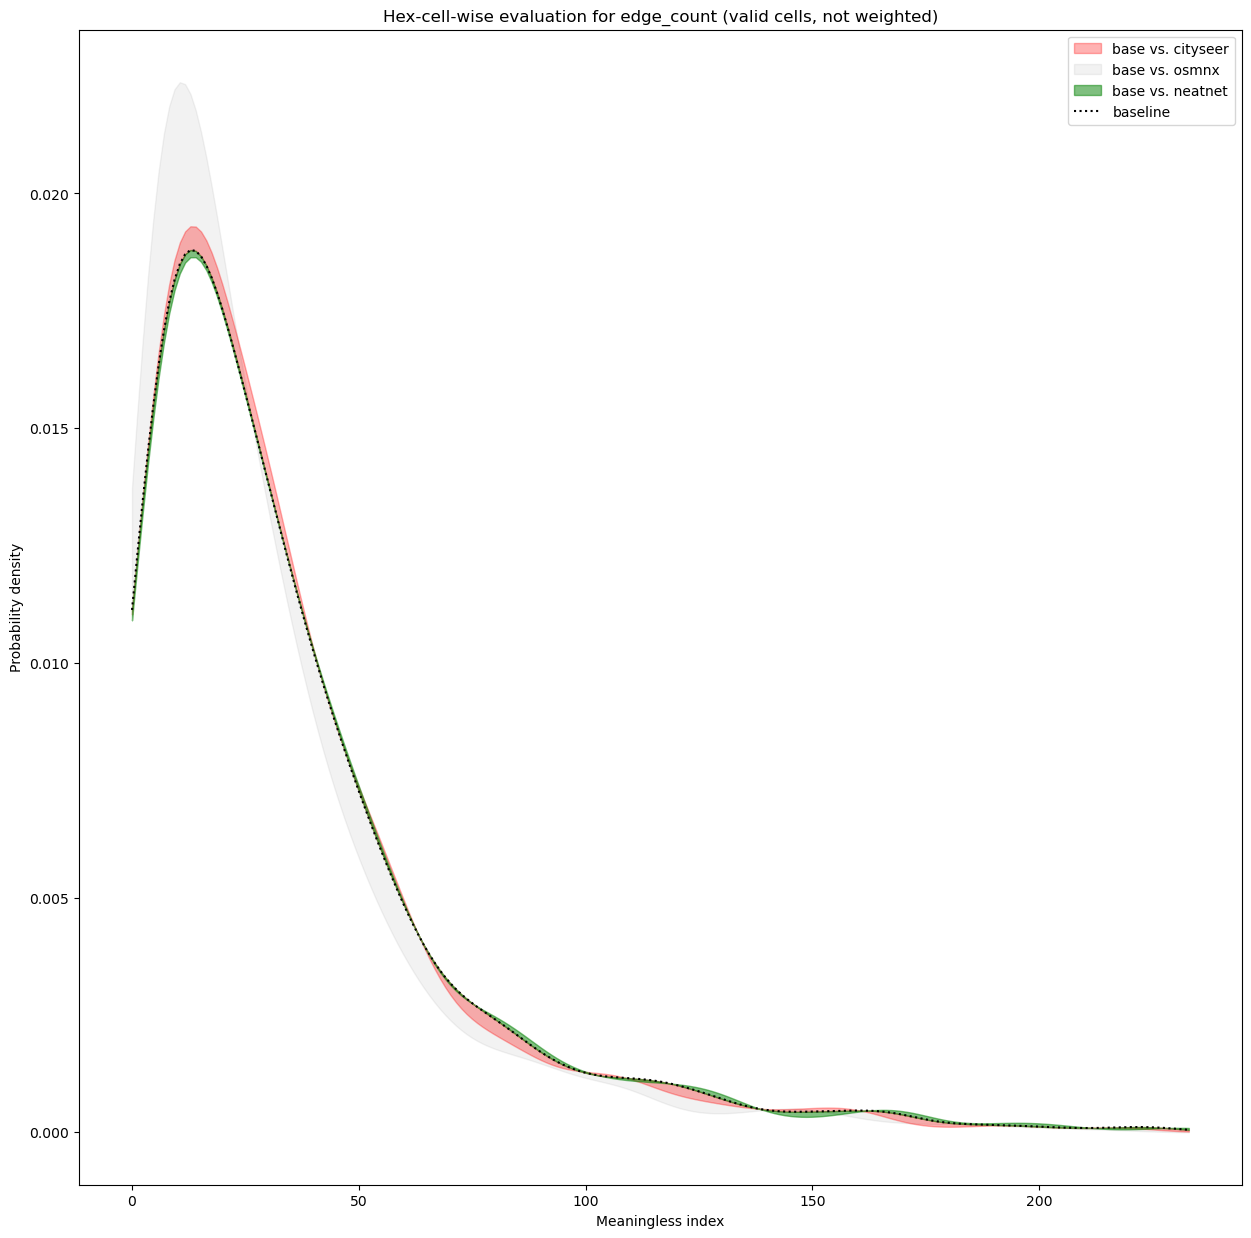

In [230]:
# set evaluation variable
eval_var = eval_vars[0]
methods_to_compare = ["cityseer", "osmnx", "neatnet"]

# weights for this variable are the values of this variable normed to the max of this variable in ORIGINAL data, per grid cell
eval_var_max = max(methods["original"]["grid"][eval_var])
weights = methods["original"]["grid"][eval_var] / eval_var_max

# mask of cells to exclude from evaluation
mask = deltas.to_verify_total == 0

exclude_cells_to_verify = True
cell_label = "(valid cells, " if exclude_cells_to_verify else "(all cells, "

weights = False
weight_label = "weighted)" if weights else "not weighted)"


#### generate KDE PDFs

kdes = {}

for method in methods_to_compare:
    # print(f"evaluating {eval_var} for {method}")

    # absolute diffs baseline for this eval var
    delta_comp = (
        methods["original"]["grid"][eval_var] - methods[method]["grid"][eval_var]
    )
    delta_base = (
        methods["original"]["grid"][eval_var] - methods["manual"]["grid"][eval_var]
    )
    # delta base is the same for each method (because it is based on orig-manual)
    # keeping it in the for loop for confusion minimization

    if weights:
        delta_base = delta_base * weights
        delta_comp = delta_comp * weights

    if exclude_cells_to_verify:
        delta_base = delta_base[mask]
        delta_comp = delta_comp[mask]

    kdes[method] = {}
    kdes[method]["base"] = gaussian_kde(delta_base)
    kdes[method]["comp"] = gaussian_kde(delta_comp)
    kdes[method]["max"] = max([max(delta_base), max(delta_comp)])


# get linspace for KDE
mymin = 0
mymax = max([kdes[method]["max"] for method in methods_to_compare])
mypoints = 200
mylinspace = np.linspace(mymin, mymax, mypoints)

# make plot
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
for method in methods_to_compare:
    ax.fill_between(
        mylinspace,
        kdes[method]["comp"](mylinspace),
        kdes[method]["base"](mylinspace),
        color=coldict[method],
        alpha=alphas[method],
        label=f"base vs. {method}",
        zorder=zorders[method],
    )
ax.plot(
    mylinspace,
    kdes[method]["base"](mylinspace),
    color="black",
    label="baseline",
    linestyle="dotted",
)
ax.set_xlabel("Meaningless index")
ax.set_ylabel("Probability density")
ax.set_title(f"Hex-cell-wise evaluation for {eval_var} {cell_label}{weight_label}")
ax.legend()
plt.show()